In [1]:
import random
from animalai.environment import AnimalAIEnvironment
from test_utils import generate_animalai_path
from wrappers import CustomUnityToGymWrapper
from animalai_agent import AnimalAIVectorhashAgent
from vectorhash import build_vectorhash_architecture
from smoothing import PolynomialSmoothing, IdentitySmoothing
import random
from shifts import RatShiftWithCompetitiveAttractorDynamics

### vhash
shapes = [(3, 3, 4), (4, 4, 5)]
model = build_vectorhash_architecture(
    shapes,
    N_h=1200,
    input_size=84 * 84,
    initalization_method="by_sparsity",
    smoothing=IdentitySmoothing(),
    shift=RatShiftWithCompetitiveAttractorDynamics(
        sigma_xy=0.3,
        sigma_theta=0.3,
        inhibition_constant=0.004,
        delta_gamma=1
    ),
    limits=(40, 40, 360),
    relu=True,
    percent_nonzero_relu=0.2,
)


### animalai
aai_seed = 0
port = 5005 + random.randint(
    0, 1000
)  # uses a random port to avoid problems if a previous version exits slowly
env_path = "/home/ezrahuang/AAI/LINUX/AAI.x86_64"
configuration_file = "./animal_ai_environments/yroom.yaml"
watch = True

aai_env = AnimalAIEnvironment(
    file_name=env_path,  # Path to the environment
    seed=aai_seed,  # seed for the pseudo random generators
    arenas_configurations=configuration_file,
    play=False,  # note that this is set to False for training
    base_port=port,  # the port to use for communication between python and the Unity environment
    inference=False,  # set to True if you want to watch the agent play
    useCamera=True,  # set to False if you don't want to use the camera (no visual observations)
    resolution=84,
    useRayCasts=False,  # set to True if you want to use raycasts
    no_graphics=False,  # set to True if you don't want to use the graphics ('headless' mode)
    timescale=1,
)

env = CustomUnityToGymWrapper(
    aai_env, uint8_visual=False, allow_multiple_obs=True, flatten_branched=True
)  # the wrapper for the environment
agent = AnimalAIVectorhashAgent(model, env)
path = generate_animalai_path(path_length=20)

by_sparsity
module shapes:  [(3, 3, 4), (4, 4, 5)]
N_g     :  116
N_patts :  2880
N_h     :  1200
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"


/home/ezrahuang/Projects/rl-research/vectorhash/hippocampal_sensory_layers.py:107: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  1 + input.T @ self.inhibition_matrix_hs @ input


info for each h directly after learning it
h max, min, mean tensor(3.2862) tensor(0.) tensor(0.1487)
h_from_s max, min, mean tensor(3.2852) tensor(0.) tensor(0.1487)
h_from_s_denoised max, min, mean tensor(15.7538) tensor(0.) tensor(1.9333)
avg nonzero/greaterzero h from book: tensor(244) tensor(244)
avg nonzero/greaterzero h from s: tensor(244) tensor(244)
avg nonzero/greaterzero h from s denoised: tensor(523) tensor(523)
mse/cosinesimilarity h from book and h from s tensor(1.7661e-08) tensor([1.])
mse/cosinesimilarity h from book and h from s denoised tensor(12.5007) tensor([0.4475])
mse/cosinesimilarity s and s from h from s tensor(1.2902e-06) tensor([1.0000])
mse/cosinesimilarity s and s from h from s denoised tensor(0.0190) tensor([1.0000])
mse/cosinesimilarity s and s from h tensor(1.2577e-06) tensor([1.0000])


/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:81: UserWarning: Using a target size (torch.Size([1, 1200])) that is different to the input size (torch.Size([1200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:88: UserWarning: Using a target size (torch.Size([1, 1200])) that is different to the input size (torch.Size([1200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:104: UserWarning: Using a target size (torch.Size([1, 7056])) that is different to the input size (torch.Size([7056])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(s, s_from_h_from_

In [2]:
agent.test_path(path)

img.shape (3, 84, 84)
obs.shape [84, 84, 3]
info for each h directly after learning it
h max, min, mean tensor(3.2862) tensor(0.) tensor(0.1487)
h_from_s max, min, mean tensor(3.2858) tensor(0.) tensor(0.1487)
h_from_s_denoised max, min, mean tensor(15.7568) tensor(0.) tensor(1.9337)
avg nonzero/greaterzero h from book: tensor(244) tensor(244)
avg nonzero/greaterzero h from s: tensor(244) tensor(244)
avg nonzero/greaterzero h from s denoised: tensor(523) tensor(523)
mse/cosinesimilarity h from book and h from s tensor(3.1630e-09) tensor([1.0000])
mse/cosinesimilarity h from book and h from s denoised tensor(12.5060) tensor([0.4475])
mse/cosinesimilarity s and s from h from s tensor(0.0001) tensor([0.9998])
mse/cosinesimilarity s and s from h from s denoised tensor(0.0187) tensor([0.9998])
mse/cosinesimilarity s and s from h tensor(0.0001) tensor([0.9998])
img.shape (3, 84, 84)
obs.shape [84, 84, 3]
old positions: tensor([ 40.0000,  40.0000, 360.0000])
padded shape: torch.Size([4, 5, 5]

/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:81: UserWarning: Using a target size (torch.Size([1, 1200])) that is different to the input size (torch.Size([1200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:88: UserWarning: Using a target size (torch.Size([1, 1200])) that is different to the input size (torch.Size([1200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:104: UserWarning: Using a target size (torch.Size([1, 7056])) that is different to the input size (torch.Size([7056])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(s, s_from_h_from_

padded shape: torch.Size([1, 3, 3, 6])
updated shape: torch.Size([9, 1, 4])
padded shape: torch.Size([5, 7, 7])
updated shape: torch.Size([5, 1, 4, 4])
P shape: torch.Size([1, 5, 4, 4])
padded shape: torch.Size([1, 4, 4, 7])
updated shape: torch.Size([16, 1, 5])
new positions: tensor([39.7319,  0.3014,  6.1258])
info for each h directly after learning it
h max, min, mean tensor(2.0180) tensor(0.) tensor(0.0490)
h_from_s max, min, mean tensor(1.9932) tensor(0.) tensor(0.0502)
h_from_s_denoised max, min, mean tensor(6.6607) tensor(0.) tensor(0.5231)
avg nonzero/greaterzero h from book: tensor(130) tensor(130)
avg nonzero/greaterzero h from s: tensor(345) tensor(345)
avg nonzero/greaterzero h from s denoised: tensor(380) tensor(380)
mse/cosinesimilarity h from book and h from s tensor(3.2204e-05) tensor([0.9996])
mse/cosinesimilarity h from book and h from s denoised tensor(1.2515) tensor([0.5216])
mse/cosinesimilarity s and s from h from s tensor(1.5343e-06) tensor([1.0000])
mse/cosinesi

([tensor([0.0000e+00, 0.0000e+00, 3.0518e-05])],
 [8, 5, 7, 4, 1, 6, 8, 7, 1, 1, 5, 2, 1, 5, 3, 3, 8, 2, 4, 1])

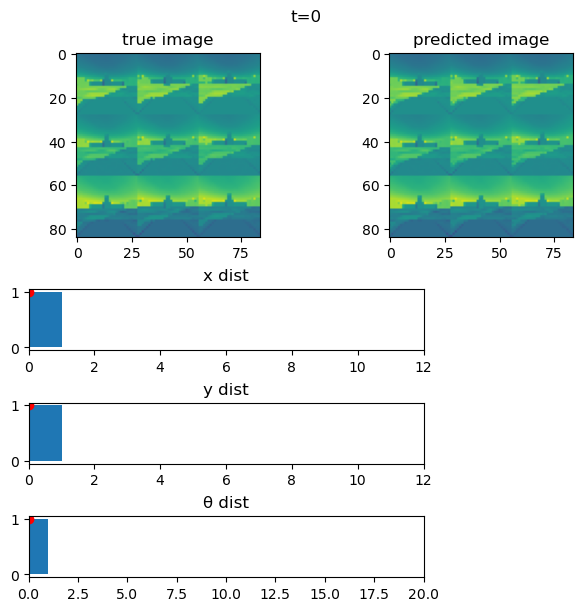

In [3]:
ani = agent.history.make_image_video()

In [ ]:
ani.save(
    "test_20.mp4",
    progress_callback=lambda current, total: print(f"frame {current+1}/{total}"),
    dpi=150,
)

frame 0/20
frame 1/20
frame 2/20
frame 3/20
frame 4/20
frame 5/20
frame 6/20
frame 7/20
frame 8/20
frame 9/20
frame 10/20
frame 11/20
frame 12/20
frame 13/20
frame 14/20
frame 15/20
frame 16/20
frame 17/20
frame 18/20
frame 19/20


In [5]:
env.close()